In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.proteoscopemodule import ProteoscopeLightningModule
import numpy as np
from omegaconf import OmegaConf


BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/15-38-19" # un-conditioned - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/17-33-19" # one-hot - looks good
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/18-58-47" # mean
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/16-34-38" # 25 x 25 cond latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/22-36-50" # 25 x 25 cond nuclei + latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-05/01-50-26" # 25 x 25 cond nuclei + latent

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    plm = ProteoscopeLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        unet_number=1,
    )

    plm.unet.eval()
    plm.unet.cuda()
    plm.cytoself_model.cuda()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_9309/2008125569.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-08-03/18-58-47/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:36: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [2]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels.drop_duplicates(subset='ensg')
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)

In [2]:
# pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels.drop_duplicates(subset='ensg')
pdm.val_proteins_dataset.labels = pdm.val_proteins_dataset.labels[pdm.val_proteins_dataset.labels['localization'] != '']
dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [3]:
# pdm.train_dataset.labels = pdm.train_dataset.labels.drop_duplicates(subset='ensg')
# dl = pdm.train_dataloader()

In [4]:
# dl = pdm.val_dataloader(novel_proteins=True, shuffle=True)

In [4]:
plm.cond_images

False

In [6]:
# from tqdm import tqdm

# outputs = []
# locs = []

# # batch = next(iter(dl))
# # cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()

# for batch in tqdm(dl):
#     output = plm.sample(batch, cond_scale=3, cond_images=None).detach().cpu().numpy()

#     # vq_outputs = plm.cytoself_model.vq_layers[1](output_encoded_images)
#     # output_vqvae2 = vq_outputs[1].detach().cpu().numpy()
    
#     locs.append(np.array(batch['localization']))
#     outputs.append(output)
#     # outputs.append(output_encoded_images.detach().cpu().numpy())
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)

In [7]:
# locs = np.concatenate(locs, axis=0)
# outputs = np.concatenate(outputs, axis=0)
# inputs = np.concatenate(inputs, axis=0)

In [5]:
import torch

In [6]:
from tqdm import tqdm

true_images = []
true_localizations = []
predicted_images = []
predicted_latents = []
true_latents = []

# batch = next(iter(dl))
# cond_images_base = batch['image'][0, 1, :, :].unsqueeze(dim=0).unsqueeze(dim=0).cuda()
for _ in range(1):
    for batch in tqdm(dl):
        batch['image'] = batch['image'].cuda()
        output = plm.sample(batch, guidance_scale=3, cond_images=None)
        # output2 = plm2.sample(batch, cond_scale=3, cond_images=None)

        plm.cytoself_model.mse_loss = {}
        input_image = batch['image'].cuda()
        true_latent = plm.cytoself_model(input_image, 'vqvec2').float()
        # true_latent2 = plm2.cytoself_model(input_image, plm2.cytoself_layer).float()
        # output_image = plm.cytoself_model._connect_decoders([output, output2])
        # output2 = torch.randn_like(output2)
        # true_latent = torch.randn_like(true_latent)
        # output_image = plm.cytoself_model._connect_decoders([output, true_latent])
        

        true_images.append(input_image.detach().cpu().numpy())
        true_localizations.append(np.array(batch['localization']))
        true_latents.append(true_latent.detach().cpu().numpy())
        predicted_latents.append(output.detach().cpu().numpy())
        # predicted_images.append(output_image.detach().cpu().numpy())

predicted_latents = np.concatenate(predicted_latents, axis=0)
true_images = np.concatenate(true_images, axis=0)
true_localizations = np.concatenate(true_localizations, axis=0)
# predicted_images = np.concatenate(predicted_images, axis=0)
true_latents = np.concatenate(true_latents, axis=0)

  0%|          | 0/568 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 1/568 [00:06<1:03:13,  6.69s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 2/568 [00:10<48:14,  5.11s/it]  

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 3/568 [00:14<43:17,  4.60s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 4/568 [00:18<40:48,  4.34s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 5/568 [00:22<39:26,  4.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 6/568 [00:26<38:43,  4.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 7/568 [00:30<38:16,  4.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|▏         | 8/568 [00:35<39:52,  4.27s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 9/568 [00:39<38:51,  4.17s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 10/568 [00:43<38:20,  4.12s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 11/568 [00:47<37:56,  4.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 12/568 [00:51<37:41,  4.07s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 13/568 [00:55<37:47,  4.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 14/568 [00:59<38:38,  4.19s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 15/568 [01:03<38:06,  4.13s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 16/568 [01:07<37:33,  4.08s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 17/568 [01:11<37:14,  4.05s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 18/568 [01:15<36:54,  4.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 19/568 [01:19<36:40,  4.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▎         | 20/568 [01:23<36:34,  4.01s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▎         | 21/568 [01:27<36:26,  4.00s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 22/568 [01:31<36:17,  3.99s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 23/568 [01:35<36:07,  3.98s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 24/568 [01:39<35:53,  3.96s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  4%|▍         | 25/568 [01:43<35:49,  3.96s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▍         | 26/568 [01:47<35:41,  3.95s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▍         | 27/568 [01:51<35:40,  3.96s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  5%|▍         | 27/568 [01:53<37:49,  4.20s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 for _ in range(1):                                                                          │
│   12 │   for batch in tqdm(dl):                                                                  │
│   13 │   │   batch['image'] = batch['image'].cuda()                                              │
│ ❱ 14 │   │   output = plm.sample(batch, guidance_scale=3, cond_images=None)                      │
│   15 │   │   # output2 = plm2.sample(batch, cond_scale=3, cond_images=None)                      │
│   16 │   │                                                                                       │
│   17 │   │   plm.cytoself_model.mse_loss = {}                                                    │
│                                                                                                  │
│ /home/ec2-user/proteoscope/proteoscope/proteoscopemodule.py:176 in sample                        │
│                                                                                                  │
│   173 │   │   │                                                                                  │
│   174 │   │   │   # predict the noise residual                                                   │
│   175 │   │   │   with torch.no_grad():                                                          │
│ ❱ 176 │   │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=seq_   │
│   177 │   │   │                                                                                  │
│   178 │   │   │   # perform guidance                                                             │
│   179 │   │   │   noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)                       │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1190 in           │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1187 │   │   # this function, and just call forward.                                           │
│   1188 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1189 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1190 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1191 │   │   # Do not call functions when jit is used                                          │
│   1192 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1193 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:956 in │
│ forward                                                                                          │
│                                                                                                  │
│   953 │   │   │   │   upsample_size = down_block_res_samples[-1].shape[2:]                       │
│   954 │   │   │                                                                                  │
│   955 │   │   │   if hasattr(upsample_block, "has_cross_attention") and upsample_block.has_cro   │
│ ❱ 956 │   │   │   │   sample = upsample_block(                                                   │
│   957 │   │   │   │   │   hidden_states=sample,            

In [7]:
# predicted_latents = np.concatenate(predicted_latents, axis=0)
# true_images = np.concatenate(true_images, axis=0)
# true_localizations = np.concatenate(true_localizations, axis=0)
# # predicted_images = np.concatenate(predicted_images, axis=0)
# true_latents = np.concatenate(true_latents, axis=0)

In [8]:
# print(predicted_images.shape)
print(predicted_latents.shape)

(1728, 64, 4, 4)


In [12]:
import matplotlib.pyplot as plt

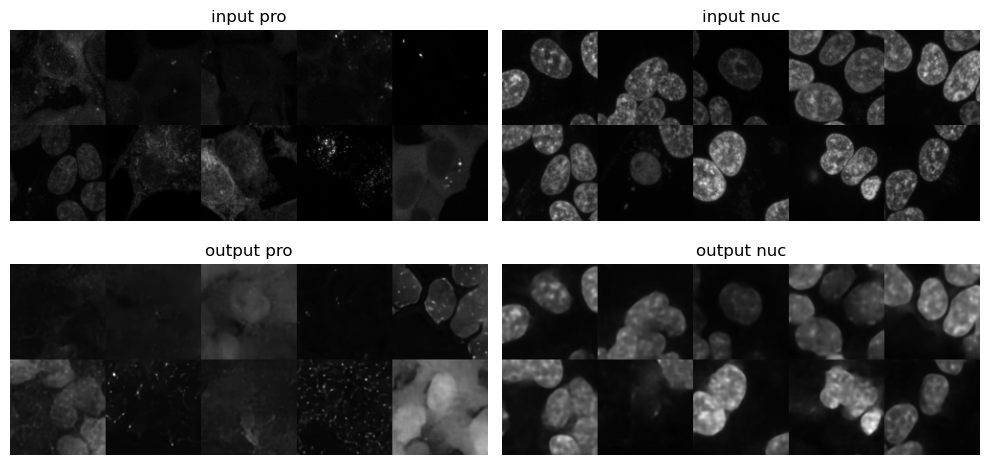

: 

In [13]:
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(true_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(predicted_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [9]:
# def merge_images(img_A, img_B):
#     rgb = np.tile(img_A, (3, 1, 1)).transpose(1, 2, 0)
#     rgb[:, :, 1] = img_B
#     return rgb

In [10]:
# plt.imshow(merge_images(output_images[id], input_images[id]))

# Cytoself

In [9]:
import zarr
import numpy as np
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings_redo21.zarr")

embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "good_localizations_redo21.npy"))

In [10]:
from joblib import load

reducer = load(join(datapath,'good_umap_model_redo21.joblib'))

In [11]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'

In [12]:
import seaborn as sns

label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

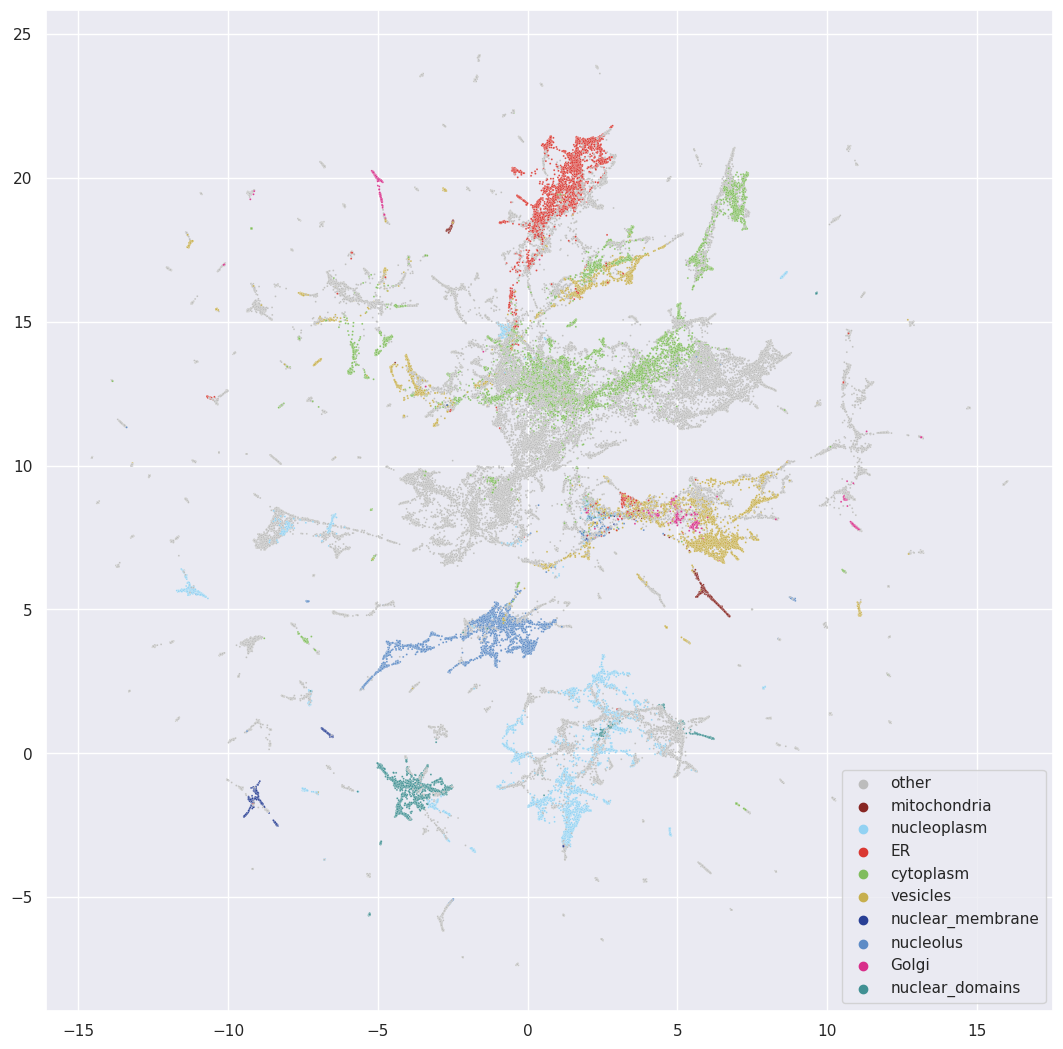

In [13]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)

In [14]:
reduced_outputs = reducer.transform(predicted_latents.reshape(predicted_latents.shape[0], -1))
reduced_locs = true_localizations
reduced_locs[reduced_locs == ''] = 'other'

<AxesSubplot:>

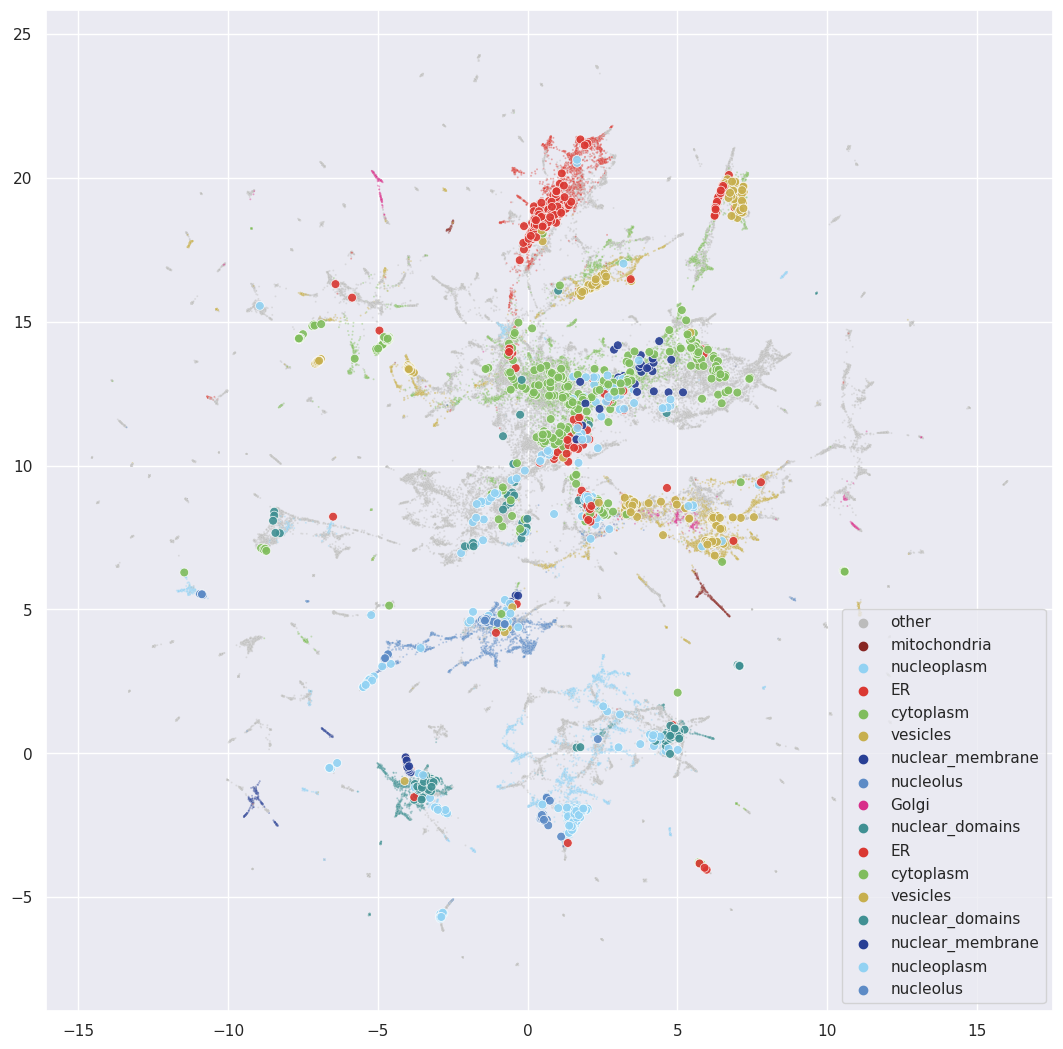

In [15]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [16]:
print(embeddings.max())
print(embeddings.min())
print(predicted_latents.min())
print(predicted_latents.max())

3.7375431060791016
-0.2739241123199463
-0.3526717
3.8576796


In [17]:
reduced_true_outputs = reducer.transform(true_latents.reshape(true_latents.shape[0], -1))

<AxesSubplot:>

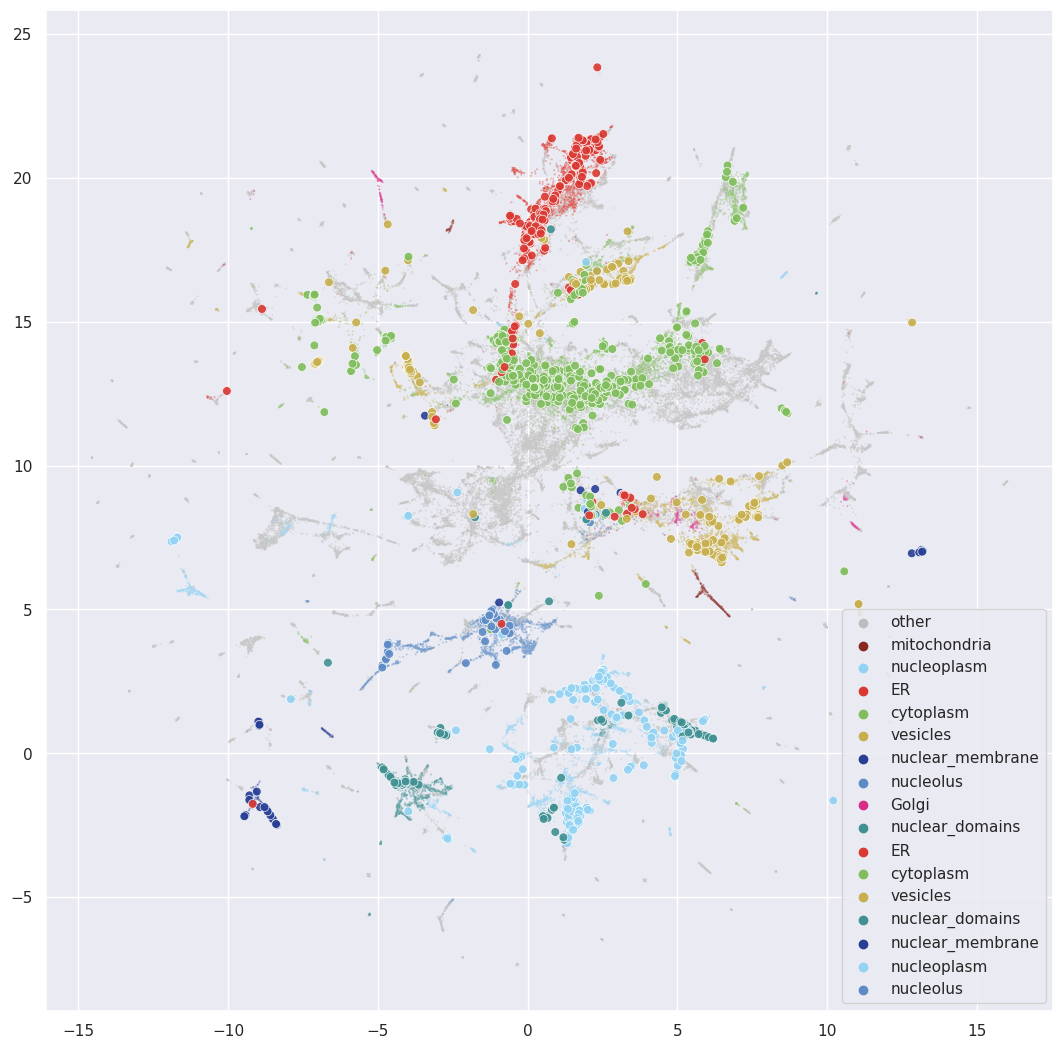

In [18]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_true_outputs[:, 0], y=reduced_true_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

### Classifications

In [19]:
from joblib import load

# Load the model from the file
clf = load('good_localization_classifier_redo21.joblib')


In [29]:
other = true_localizations == 'other'
X_test = predicted_latents[~other]
# X_test = true_latents[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = true_localizations[~other]

In [30]:
true_latents.shape

(1728, 64, 4, 4)

In [31]:
y_predict = clf.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# class_labels = np.unique(localizations[localizations != 'other'])
class_labels = np.unique(y_test)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.6342592592592593


In [33]:
import matplotlib.pyplot as plt

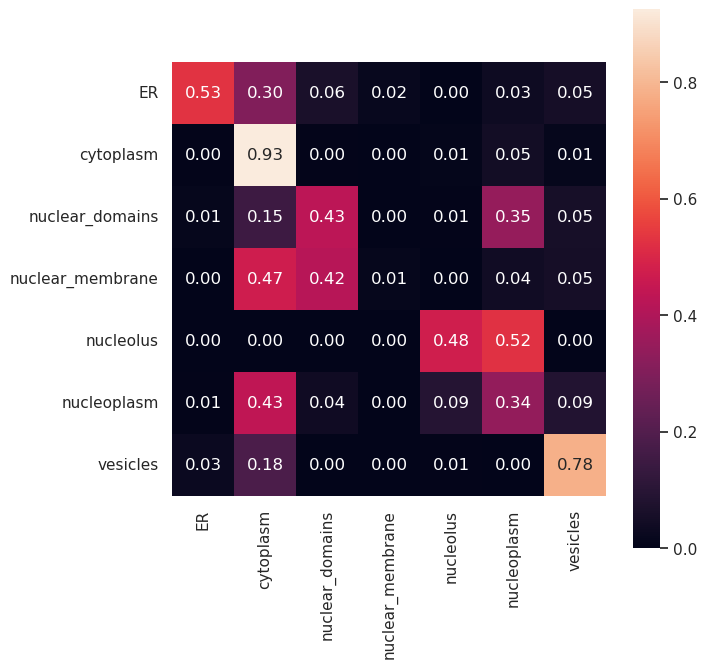

In [34]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

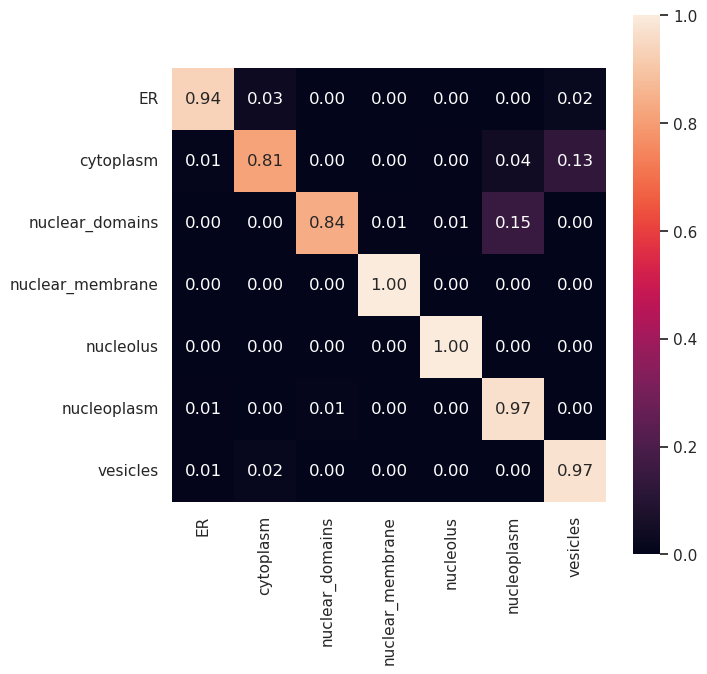

In [26]:
plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=40, alpha=0.9, palette=label_colors)

In [ ]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.4, palette=label_colors)
sns.scatterplot(x=reduced_outputs[:, 0], y=reduced_outputs[:, 1], hue=reduced_locs, s=50, alpha=0.9, palette=label_colors)